In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [136]:
uploaded = files.upload()

Saving clean_V6.csv to clean_V6 (3).csv


In [0]:
features = pd.read_csv('clean_V6.csv')
features = features.drop(columns=['ALLIANCE_LEVEL_ID', 'NET_SALES_UNITS', 'SOLD_TO_ID'])

In [0]:
decimals = 2

features['HEIGHT'] = (features['HEIGHT']/12).apply(lambda x: round(x, decimals))
features['WIDTH'] = (features['WIDTH']/12).apply(lambda x: round(x, decimals))

features['HEIGHT'] = features['HEIGHT'].astype(str)
features[['HEIGHT_FT','HEIGHT_IN']] = features.HEIGHT.str.split('.', expand=True)

features['WIDTH'] = features['WIDTH'].astype(str)
features[['WIDTH_FT','WIDTH_IN']] = features.WIDTH.str.split('.', expand=True)

In [0]:
features = features.drop(columns=['WIDTH', 'HEIGHT'])

features[['HEIGHT_FT', 'HEIGHT_IN']] = features[['HEIGHT_FT', 'HEIGHT_IN']].astype(float)
features[['WIDTH_FT', 'WIDTH_IN']] = features[['WIDTH_FT', 'WIDTH_IN']].astype(float)

features[['HEIGHT_IN', 'WIDTH_IN']] = (features[['HEIGHT_IN', 'WIDTH_IN']]/12).apply(lambda x: round(x, decimals))

features['SO_CREATED_DATE'] = features['SO_CREATED_DATE'].apply(pd.to_datetime)

features['SO_CREATED_DATE'] = features['SO_CREATED_DATE'].astype(str)
features[['SO_CREATED_DATE_Y', 'SO_CREATED_DATE_M', 'SO_CREATED_DATE_D']] = features.SO_CREATED_DATE.str.split('-', expand=True)

In [0]:
def label_season(season):
  if season['SO_CREATED_DATE_M'] in ['12','01','02']:
    return 'W' #Winter
  elif season['SO_CREATED_DATE_M'] in ['03','04','05']:
    return 'S' #Spring
  elif season['SO_CREATED_DATE_M'] in ['06','07','08']:
    return 'SR' #Summer
  else:
    return 'F' #Fall

features['SEASON'] = features.apply(lambda season: label_season(season), axis=1)

features.head()

#season_dict = {'12':'winter', '01':'winter', '02':'winter', '03':'spring', '04':'spring', '05':'spring', '06':'summer', '07':'summer', '08':'summer', '09':'fall', '10':'fall', '11':'fall'}
#features['SEASON'] = features['SO_CREATED_DATE_M'].map(season_dict)

In [0]:
def label_states (row):
    if row['REGION_STATE_ID'] in ['ME', 'NH', 'VE', 'MA', 'RI', 'CT', 'NY', 'PA', 'NJ']:
      return 'NE' #Northeast
    elif row['REGION_STATE_ID'] in ['WI', 'MI', 'IL', 'IN', 'OH', 'ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']:
      return 'MW' #Midwest
    elif row['REGION_STATE_ID'] in ['DE', 'MD', 'DC', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'MS', 'AL', 'OK', 'TX', 'AR', 'LA']:
      return 'S' #South
    else:
      return 'W' #West

features['REGION'] = features.apply(lambda row: label_states(row), axis=1)

features.head()

In [0]:
def label_height (height):
  if height['HEIGHT_FT'] in ['0.0','1.0','2.0','3.0']:
    return 'S' #Small
  elif height['HEIGHT_FT'] in ['4.0','5.0','6.0']:
    return 'M' #Medium
  else:
    return 'L' #Large

features['HEIGHT_bin'] = features.apply(lambda height: label_height(height), axis=1)

features.head()

In [0]:
def label_width (width):
  if width['WIDTH_FT'] in ['1','2','3','4']:
    return 'S' #Small
  elif width['WIDTH_FT'] in ['5','6','7','8']:
    return 'M' #Medium
  else:
    return 'L' #Large

features['WIDTH_bin'] = features.apply(lambda width: label_width(width), axis=1)

features.head()

In [0]:
features = features.reindex(columns=['REGIONAL_SALES_MGR_ID','REGION_STATE_ID','FABRIC_ID','ORIGINAL_MATERIAL_ID','SO_CREATED_DATE','HEIGHT_FT','HEIGHT_IN','HEIGHT_bin','WIDTH_FT','WIDTH_IN','WIDTH_bin','SO_CREATED_DATE_Y','SO_CREATED_DATE_M','SO_CREATED_DATE_D','SEASON','REGION','REJECT'])

features = features.drop(columns=['REGION_STATE_ID','SO_CREATED_DATE']) #May need to drop more features

features.head()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

np.random.seed(0)

In [147]:
features['REJECT'].value_counts() #0,1 check, data set imbalanced

0    10374
1      604
Name: REJECT, dtype: int64

In [0]:
#rebalance data set using sklearn resample
df_majority = features[features.REJECT==0] #majority of REJECT column
df_minority = features[features.REJECT==1] #minority of REJECT column

In [0]:
#resample data to have minority class equal majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10374,    # to match majority class
                                 random_state=123) # reproducible results

In [0]:
#concatenate df_majority and df_minority_upsampled together after rebalance
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [151]:
#verifiction of resampling; 0 and 1 count now equal; data rebalanced
df_upsampled.REJECT.value_counts()

1    10374
0    10374
Name: REJECT, dtype: int64

In [0]:
#reassign the resampled data back into the features variable
features = df_upsampled
features.head()

In [0]:
numeric_features = ['HEIGHT_FT','HEIGHT_IN','WIDTH_FT','WIDTH_IN']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['FABRIC_ID','ORIGINAL_MATERIAL_ID','SEASON','REGION','WIDTH_bin','HEIGHT_bin']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [0]:
classifiers = [
    #LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    #SVC(kernel='linear', 
            #class_weight='balanced', # penalize
            #probability=True),
    #GaussianNB()
    #MLPClassifier(),
    KNeighborsClassifier()
]

In [0]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', None)])

In [0]:
# y are the values we want to predict
y = np.array(features['REJECT'])
# Remove the labels from the features
# axis 1 refers to the columns
X = features.drop('REJECT', axis = 1)
# Saving feature names for later use
X_list = list(X.columns)
X_list

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [0]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

In [0]:
roc_things = []
precision_recall_things = []

In [162]:
for classifier in classifiers:
    clf.set_params(clf=classifier).fit(X_train, y_train)
    classifier_name = classifier.__class__.__name__
    print(str(classifier))
    print('~Model Score: %.3f' % clf.score(X_test, y_test))

    y_score = clf.predict_proba(X_test)[:,1]

    y_pred = clf.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_things.append((fpr, tpr, '{} AUC: {:.3f}'.format(classifier_name, roc_auc)))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    precision_recall_things.append((recall, precision, thresholds, '{} AUC: {:.3f}'.format(classifier_name, pr_auc)))
    #plot_precision_recall_curve(clf, X_test, y_test)
    
    scores = cross_val_score(clf, X, y, cv=5)
    print('~Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

    print('~Confusion Matrix:''\n',
    confusion_matrix(y_test, y_pred))
    print('~Classification Report:''\n',
    classification_report(y_test, y_pred))
   
    print('~Average Precision Score: {:.3f}'.format(average_precision_score(y_test, y_score)))
    print('~roc_auc_score: {:.3f}'.format(roc_auc))
    print('~precision-recall AUC: {:.3f}'.format(pr_auc))
    print()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
~Model Score: 0.961
~Accuracy: 0.96 (+/- 0.00)
~Confusion Matrix:
 [[1928  162]
 [   0 2060]]
~Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      2090
           1       0.93      1.00      0.96      2060

    accuracy                           0.96      4150
   macro avg       0.96      0.96      0.96      4150
weighted avg       0.96      0.96      0.96      4150

~Average Precision Score: 0.927
~roc_auc_score: 0.961
~precision-recall AUC: 0.963

RandomForestClassifier(bootstrap=True, ccp_

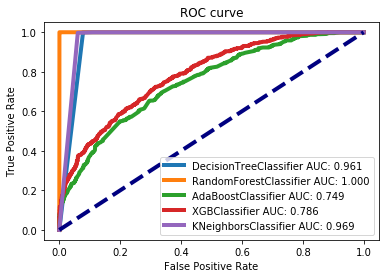

In [163]:
#ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
roc_plt = plt.figure()
lw = 4
for roc_thing in roc_things:
    fpr, tpr, label = roc_thing
    plt.plot(fpr, tpr, lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

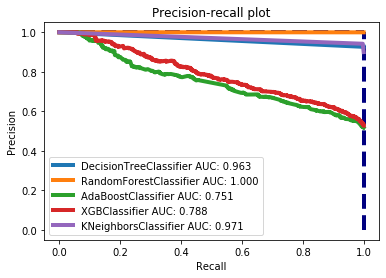

In [166]:
#Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a 
#predictive model using different probability thresholds.
pr_plt = plt.figure()
for pr_thing in precision_recall_things:
    recall, precision, _, label = pr_thing
    plt.plot(recall, precision, lw=lw, label=label)
ratio = y_test[y_test].shape[0] / y_test.shape[0]
plt.hlines(y=ratio, xmin=0, xmax=1, color='navy', lw=lw, linestyle='--')
plt.vlines(x=ratio, ymin=0, ymax=1, color='navy', lw=lw, linestyle='--')
plt.title('Precision-recall plot')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [167]:
from scipy.stats import hmean
import numpy.ma as ma

recall, precision, thresholds, _ = precision_recall_things[1]

a = np.column_stack((recall,precision))

a = ma.masked_less_equal(a, 0)
a = ma.mask_rows(a)
f1 = hmean(a,axis=1)

threshold_that_maximizes_f1 = thresholds[np.argmax(f1)]
print('threshold that optimizes f1: {}'.format(threshold_that_maximizes_f1))

threshold that optimizes f1: 0.9033153529477054
